In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import a_of_chi,rad_comoving_distance
from flowpm.raytracing import  lightcone, Born, wlen
from flowpm.cosmology import Planck15
from flowpm.tfpower import linear_matter_power
import flowpm.constants as constants
import flowpm  
from astropy.io import fits

Populating the interactive namespace from numpy and matplotlib


In [2]:
nc=[64,64,640]   # size of the cube, number of cells
nc_xy= 64                # number of pixel for x and  y 
Boxsize=[200,200,2000]          # Physical size of the cube

In [3]:
#To make lens planes of size 200 Mpc/h :
cosmo = Planck15()
r = np.linspace(10,2000,10, endpoint=True)
a = a_of_chi(cosmo, r)

Text(0.5, 0, 'Mpc/h')

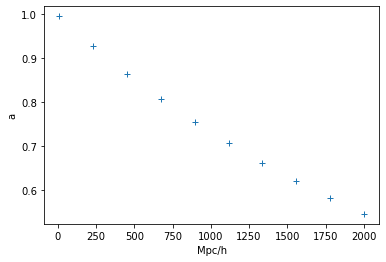

In [4]:
# This allows us to go to roughly z=1
plot(r,a, '+')
ylabel(r'a')
xlabel(r'Mpc/h')

In [5]:
# We will first run the simulation to the lowest scaler factor entering the lightcone
init_stages = tf.linspace(0.1, a[-1], 4)
initial_conditions = flowpm.linear_field(nc,    
                                            Boxsize, 
                                             lambda k: tf.cast(linear_matter_power(cosmo, k), tf.complex64),         
                                             batch_size=1)
# Sample particles
state = flowpm.lpt_init(cosmo, initial_conditions, 0.1)   
# Evolve particles down to z=0
med_state = flowpm.nbody(cosmo, state, init_stages, nc)         
# Retrieve final density field
med_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), med_state[0])

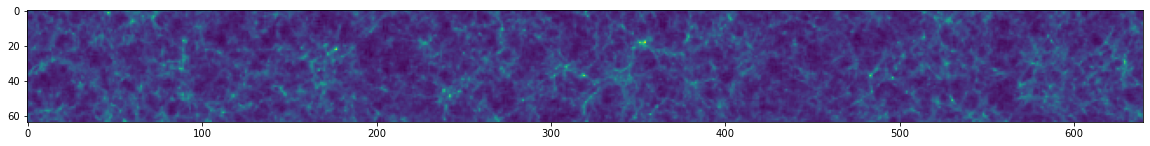

In [6]:
# At this stage we are at the right edge of the lightcone
figure(figsize=[20,5])
imshow(tf.reshape(med_field, nc).numpy().sum(axis=0))

In [7]:
final_state, lps_a, lps = lightcone(cosmo, med_state, a[::-1], 
                                    nc, 
                                    5.*60/nc_xy, nc_xy)

In [40]:
#Let's define the source's redshift
a_s=1/(1.0 + 0.7716)
ds=rad_comoving_distance(cosmo,a_s)

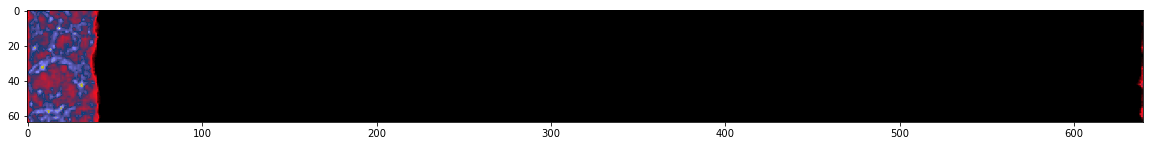

In [41]:
#Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

# And this is what remains of the simulation at redhift=0 
figure(figsize=[20,5])
imshow(tf.reshape(final_field, [nc_xy,nc_xy,-1]).numpy().sum(axis=0),cmap='gist_stern')

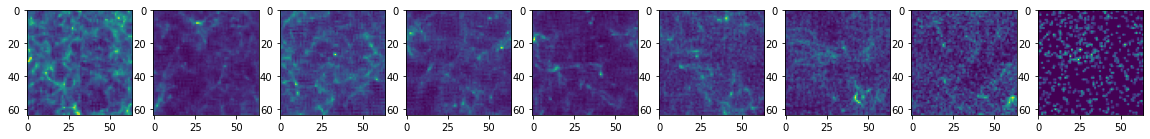

In [42]:
# Here are the lens planes exported during the simulation
figure(figsize=(20,5))
for i in range(len(lps_a)):
    subplot(1,9,i+1)
    imshow(lps[i][0]);

In [43]:
# Get convergence map by Born approximation
k_map=Born(lps_a,lps,ds,nc,Boxsize,nc_xy,5.,cosmo)

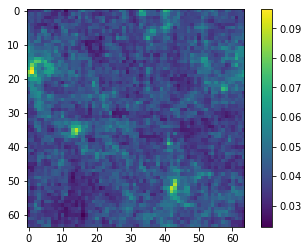

In [44]:
imshow(k_map); colorbar()

In [45]:
# Now we will export the lensplanes as LensTools DensityPlanes and use 
# LensTools to do the ray tracing

In [46]:
# Lenstools assumes that the density planes already contain all of the cosmology
# and distance factors
al = tf.stack(lps_a) # Array of scale factors
rl = rad_comoving_distance(cosmo, al) # Array of comoving distances
field = 5.
plane_size = nc_xy
A = (field * np.pi / 180 / plane_size)**2
nbar = np.prod(nc) / np.prod(Boxsize)
column_dens = (A * nbar)* rl**2
constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
# This is the factor to apply to our lensplanes to make them LensTools compatible
factor = 1./column_dens*rl/al*constant_factor

In [47]:
import lenstools as lt
import astropy.units as u
from astropy.cosmology import Planck15

In [56]:
# Create a tracer object
tracer = lt.simulations.RayTracer(lens_mesh_size=64, 
                                  lens_type=lt.simulations.DensityPlane)

# Add the lensplanes
for a_plane, plane, f, chi in zip(al, lps, factor, rl):
    lens_plane = lt.simulations.DensityPlane((plane * f).numpy()[0],            # Data
                                             5*u.deg,                     # Open angle on the sky
                                             redshift=(1/a_plane -1).numpy(),       # Redshift of the plane
                                             comoving_distance=(chi/cosmo.h).numpy()*u.Mpc,
                                             cosmology=Planck15) # Comoving distance of the plane
    tracer.addLens(lens_plane)
    
# Add an artificial plane at z=2 so that lenstools doesnt bother us
tracer.addLens(lt.simulations.DensityPlane(np.zeros((64,64)), 5.*u.deg, cosmology=Planck15))

In [57]:
# Make sure lenses are in the right order
tracer.reorderLenses()

In [58]:
# Create a grid of coordinates
xgrid, ygrid = meshgrid(linspace(0,5,64, endpoint=False),  # range of X coordinates
                        linspace(0,5,64, endpoint=False)) # range of Y coordinates
coords = stack([xgrid, ygrid], axis=0)*u.deg

In [ ]:
lt_map = tracer.convergenceBorn(coords, z=0.7716)

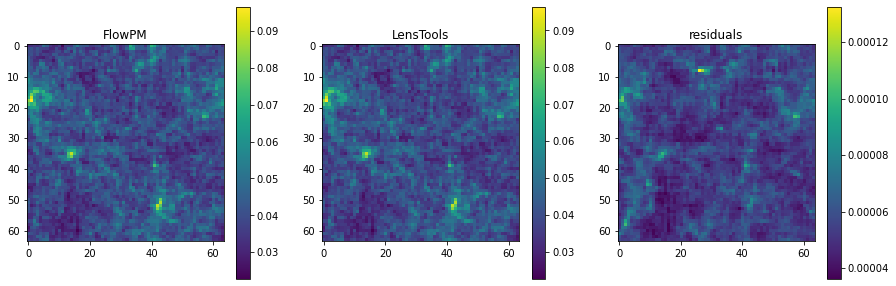

In [60]:
figure(figsize=(15,5))
subplot(131)
title('FlowPM')
imshow(k_map); colorbar()
subplot(132)
title('LensTools')
imshow(lt_map); colorbar()
subplot(133)
title('residuals')
imshow((k_map - lt_map)); colorbar()

In [61]:
kmap_flowpm = lt.ConvergenceMap(k_map, 5*u.deg)
kmap_lt = lt.ConvergenceMap(lt_map, 5*u.deg)

In [62]:
l_edges = np.arange(200.0,5000.0,200.0)
l1,Pl1 = kmap_flowpm.powerSpectrum(l_edges)
l2,Pl2 = kmap_lt.powerSpectrum(l_edges)

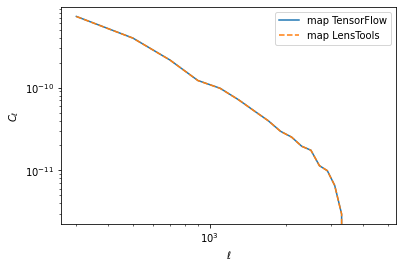

In [65]:
loglog(l1, Pl1, label='map TensorFlow')
loglog(l2, Pl2, label='map LensTools', ls='--')
xlabel('$\ell$')
ylabel('$C_{\ell}$')
legend()